# Image Analysis Project : fruits-360

## 1. 필요한 라이브러리 가져오기

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix

## 2. 데이터 로드

In [2]:
train_dir = './fruits-360/Training'
test_dir = './fruits-360/Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train_orig, y_train_orig, fruit_names_orig = load_dataset(train_dir)
x_test_orig, y_test_orig,_ = load_dataset(test_dir)

In [3]:
print('Training set size : ' , x_train_orig.shape)
print('Testing set size : ', x_test_orig.shape)

Training set size :  (67692,)
Testing set size :  (22688,)


In [4]:
no_class = len(fruit_names_orig)
print("class 개수:", no_class)

class 개수: 131


In [5]:
fruit_names_orig

array(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1',
       'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith',
       'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
       'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2',
       'Apricot', 'Avocado', 'Avocado ripe', 'Banana',
       'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry',
       'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula',
       'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier',
       'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
       'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk',
       'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
       'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink',
       'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4',
       'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut',
       'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lem

### ** 데이터 수가 너무 많아 메모리 문제 발생. 구글 colab은 업로드 문제 발생. 데이터 줄이기로 결정

In [6]:
# 파생된 카테고리중에서 대표 카테고리만 추출하여 저장

first_class = ""
fruit_names = []

for name in fruit_names_orig:
    if name.find(" ") == -1:
        if first_class != name : 
            first_class = name
            fruit_names.append(name)        
    else:
        name_index = name.find(" ")
        if first_class != name[:name_index] : 
            first_class = name[:name_index]
            fruit_names.append(name) 

In [7]:
no_class = len(fruit_names)
print("class 개수:", no_class)
print(fruit_names)

class 개수: 67
['Apple Braeburn', 'Apricot', 'Avocado', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cauliflower', 'Cherry 1', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nut Forest', 'Onion Red', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepino', 'Pepper Green', 'Physalis', 'Pineapple', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Walnut', 'Watermelon']


In [8]:
# load_dataset 함수 재정의하여 fruit_names에 있는 과일들만 가져오기 (random함수 따로 필요)

import random

def load_dataset(dirt):
    total = []
    for i in fruit_names:
        path = os.path.join(dirt, i)
        number = fruit_names.index(i)
        for img in os.listdir(path):
            total.append([os.path.join(path,img), number])
    return total

def shuffle_separation(data):
    random.shuffle(data)
    files = []
    targets = []
    for features,label in data:
        files.append(features)
        targets.append(label)
    return files, targets

x_train_org, y_train_org = shuffle_separation(load_dataset(train_dir))
x_test_org, y_test_org = shuffle_separation(load_dataset(test_dir))

In [9]:
print('Training set size : ' , len(x_train_org))
print('Testing set size : ', len(x_test_org))

Training set size :  33665
Testing set size :  11303


## 3. 데이터 탐색 및 전처리

### 1) x 데이터 정제

In [10]:
x_train_org[:10]

['./fruits-360/Training\\Banana\\r_225_100.jpg',
 './fruits-360/Training\\Kohlrabi\\r_39_100.jpg',
 './fruits-360/Training\\Mango\\87_100.jpg',
 './fruits-360/Training\\Guava\\r_75_100.jpg',
 './fruits-360/Training\\Apple Braeburn\\223_100.jpg',
 './fruits-360/Training\\Avocado\\r_198_100.jpg',
 './fruits-360/Training\\Quince\\r_279_100.jpg',
 './fruits-360/Training\\Dates\\219_100.jpg',
 './fruits-360/Training\\Peach\\240_100.jpg',
 './fruits-360/Training\\Pear\\r_281_100.jpg']

In [11]:
#RGB값을 가지는 이미지 배열로 변환(너무 오래 걸리고 자주 다운됨)
#def image_to_array(files):
#    images_as_array=[]
#    for file in files:
#        # Convert to Numpy Array
#        images_as_array.append(img_to_array(load_img(file)))
#    return images_as_array

In [12]:
#RGB값을 가지는 이미지 배열로 변환
def image_to_array(files):
    images_as_array=[]
    for file in files:
        img_array=cv2.imread(file)
        img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        images_as_array.append(img_array)
    return images_as_array

In [13]:
x_train_org2 = np.array(image_to_array(x_train_org))
x_test_org2 = np.array(image_to_array(x_test_org))
print("image to array sucessful")

image to array sucessful


In [14]:
x_train_org2[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

### 2) y 데이터 정제

In [15]:
y_train_org[:10]

[3, 28, 34, 23, 0, 2, 56, 16, 45, 46]

In [16]:
# one hot vector로 변환 (CNN output구조에 맞게)
y_train = np_utils.to_categorical(y_train_org, no_class)
y_test = np_utils.to_categorical(y_test_org, no_class)
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### 3) 시각화해서 살펴보기

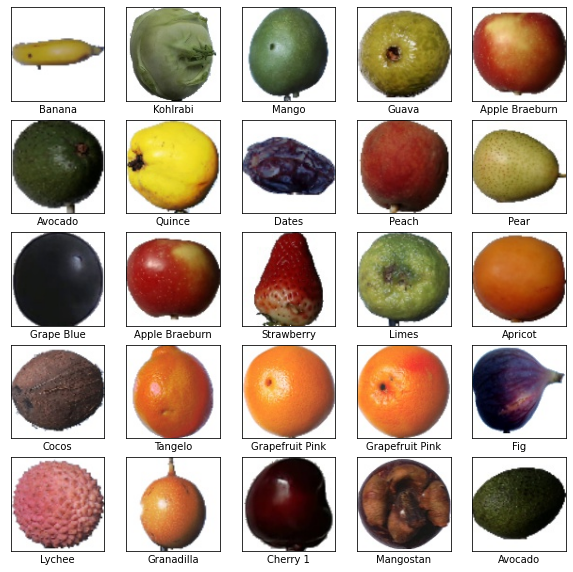

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_org2[i].astype("uint8"), cmap=plt.cm.binary)
    plt.xlabel(fruit_names[y_train_org[i]])
plt.show()

### 4) shape확인 및 validation data 나누기

In [18]:
print(x_train_org2.shape)
print(y_train.shape)
print(x_test_org2.shape)
print(y_test.shape)

(33665, 100, 100, 3)
(33665, 67)
(11303, 100, 100, 3)
(11303, 67)


In [19]:
# test 데이터에서 validation 데이터로 나누기
x_test_org2, x_val_org2 = x_test_org2[6000:],x_test_org2[:6000]
y_test, y_val = y_test[6000:],y_test[:6000]

print(x_val_org2.shape)
print(y_val.shape)
print(x_test_org2.shape)
print(y_test.shape)

(6000, 100, 100, 3)
(6000, 67)
(5303, 100, 100, 3)
(5303, 67)


### 5) 데이터 normalization

In [20]:
# normalization
x_train = x_train_org2 / 255
x_train[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [21]:
x_val = x_val_org2 / 255
x_test = x_test_org2 / 255

## 4. 간단한 구조의 CNN 모델 생성 및 학습 (model1)

In [56]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same',input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation= 'relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation= 'relu',padding='same'))
model.add(MaxPooling2D())

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150, activation= 'relu'))
model.add(Dense(67, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

In [57]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
batch_size = 32
epochs = 5

history = model.fit(x_train, y_train,
        batch_size = batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val))

Epoch 1/5
1053/1053 [==============================] - 556s 516ms/step - loss: 0.4125 - accuracy: 0.8929 - val_loss: 0.2044 - val_accuracy: 0.9562
Epoch 2/5
1053/1053 [==============================] - 387s 367ms/step - loss: 0.0391 - accuracy: 0.9892 - val_loss: 0.2657 - val_accuracy: 0.9477
Epoch 3/5
1053/1053 [==============================] - 279s 265ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.1861 - val_accuracy: 0.9650
Epoch 4/5
1053/1053 [==============================] - 291s 277ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 0.1730 - val_accuracy: 0.9692
Epoch 5/5
1053/1053 [==============================] - 289s 275ms/step - loss: 1.0628e-04 - accuracy: 1.0000 - val_loss: 0.1600 - val_accuracy: 0.9715


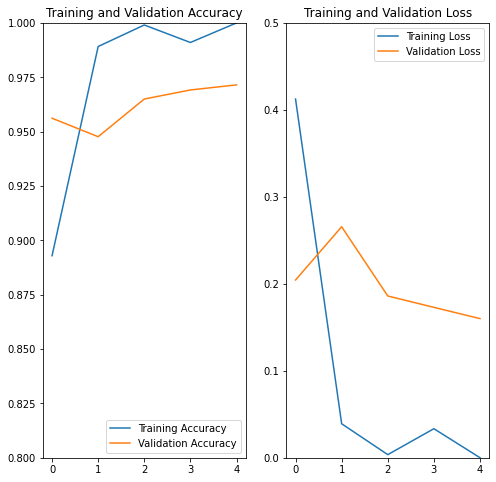

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0.8, 1.0])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.ylim([0.0, 0.5])
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. 딥한 구조의 CNN 모델 생성 및 학습 (model2)

In [28]:
model2 = Sequential()
model2.add(Conv2D(16, 3, padding='same',input_shape=(100,100,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(16, 3, activation= 'relu',padding='same'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, 3, activation= 'relu',padding='same'))
model2.add(Conv2D(32, 3, activation= 'relu',padding='same'))
model2.add(MaxPooling2D())

model2.add(Conv2D(64, 3, activation= 'relu',padding='same'))
model2.add(Conv2D(64, 3, activation= 'relu',padding='same'))
model2.add(Conv2D(64, 3, activation= 'relu',padding='same'))
model2.add(MaxPooling2D())

model2.add(Conv2D(128, 3, activation= 'relu',padding='same'))
model2.add(Conv2D(128, 3, activation= 'relu',padding='same'))
model2.add(Conv2D(128, 3, activation= 'relu',padding='same'))
model2.add(MaxPooling2D())

model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(150, activation= 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(67, activation = 'softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)       

In [29]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
batch_size = 32
epochs = 5

history2 = model2.fit(x_train,y_train,
        batch_size = batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val))

Epoch 1/5
1053/1053 [==============================] - 1320s 1s/step - loss: 2.6333 - accuracy: 0.3262 - val_loss: 0.8012 - val_accuracy: 0.7990
Epoch 2/5
1053/1053 [==============================] - 1127s 1s/step - loss: 0.3666 - accuracy: 0.8803 - val_loss: 0.4450 - val_accuracy: 0.9130
Epoch 3/5
1053/1053 [==============================] - 1121s 1s/step - loss: 0.1719 - accuracy: 0.9419 - val_loss: 0.3648 - val_accuracy: 0.9272
Epoch 4/5
1053/1053 [==============================] - 1114s 1s/step - loss: 0.1132 - accuracy: 0.9631 - val_loss: 0.4222 - val_accuracy: 0.9268
Epoch 5/5
1053/1053 [==============================] - 1076s 1s/step - loss: 0.0963 - accuracy: 0.9687 - val_loss: 0.3906 - val_accuracy: 0.9343


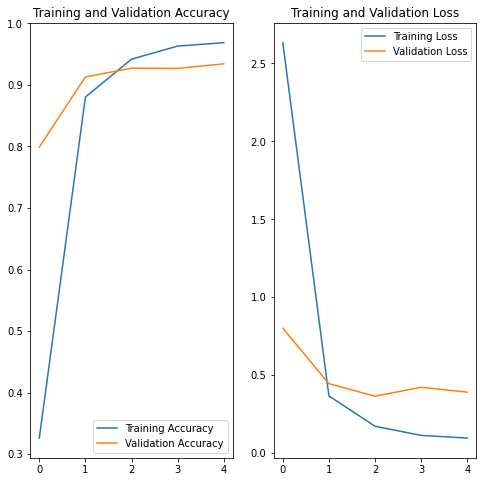

In [31]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0.2, 1.0])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.ylim([0.0, 3.0])
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. 데이터 증강을 추가한 CNN 모델 생성 및 학습 (model3)

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast(0.1,input_shape=(100, 100, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

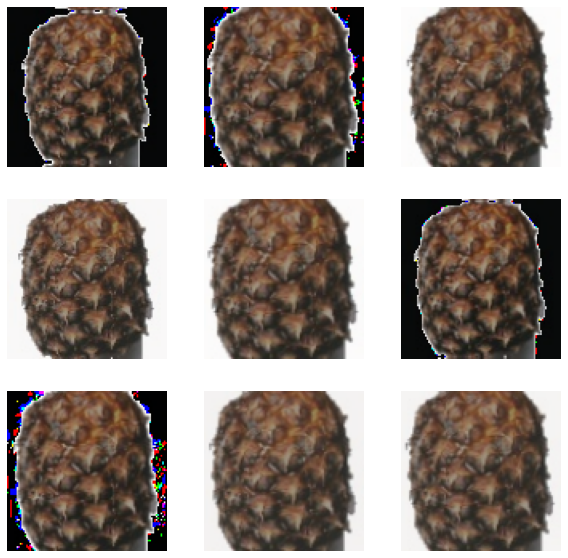

In [33]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(x_test_org2)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [34]:
model3 = Sequential()
model3.add(data_augmentation)
model3.add(Conv2D(16, 3, padding='same',input_shape=(100,100,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, 3, activation= 'relu',padding='same'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3, activation= 'relu',padding='same'))
model3.add(MaxPooling2D())

model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(150, activation= 'relu'))
model3.add(Dense(67, activation = 'softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [35]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
batch_size = 32
epochs = 5

history3 = model3.fit(x_train, y_train,
        batch_size = batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val))

Epoch 1/5
1053/1053 [==============================] - 690s 610ms/step - loss: 0.4174 - accuracy: 0.8879 - val_loss: 0.1720 - val_accuracy: 0.9613
Epoch 2/5
1053/1053 [==============================] - 466s 443ms/step - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.1295 - val_accuracy: 0.9758
Epoch 3/5
1053/1053 [==============================] - 318s 302ms/step - loss: 0.0458 - accuracy: 0.9857 - val_loss: 0.1463 - val_accuracy: 0.9730
Epoch 4/5
1053/1053 [==============================] - 312s 297ms/step - loss: 0.0166 - accuracy: 0.9957 - val_loss: 0.5857 - val_accuracy: 0.8880
Epoch 5/5
1053/1053 [==============================] - 326s 309ms/step - loss: 0.0308 - accuracy: 0.9916 - val_loss: 0.1289 - val_accuracy: 0.9803


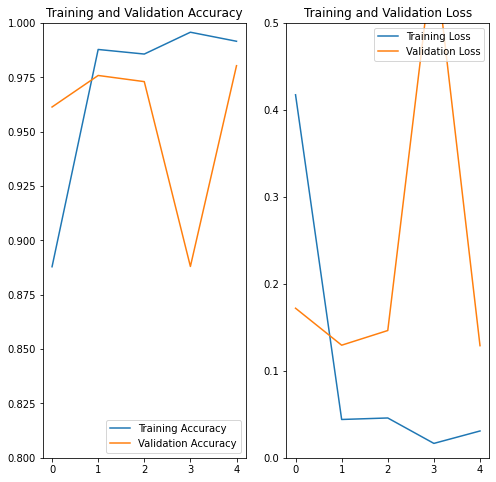

In [67]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0.8, 1.0])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.ylim([0.0, 0.5])
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7. 정확도가 제일 높은 model3으로 test 데이터 예측 및 결과 확인

In [60]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9707712531089783


In [39]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9779370427131653


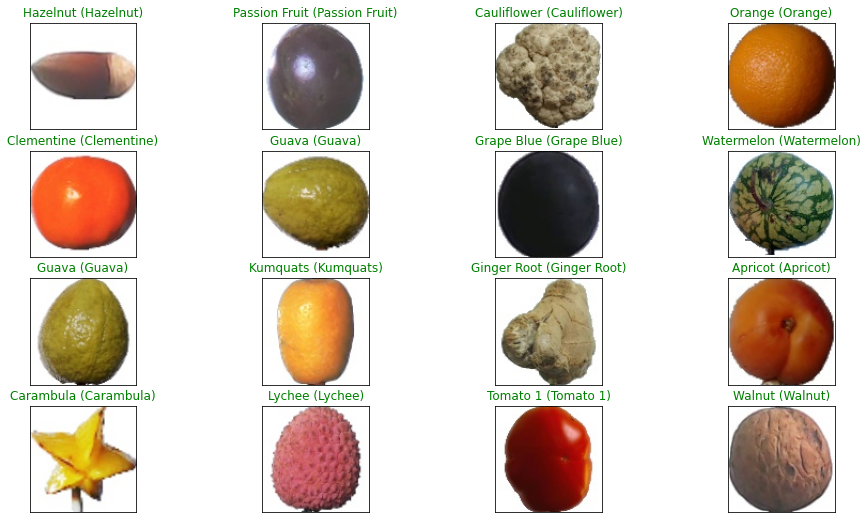

In [40]:
y_pred = model3.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(fruit_names[pred_idx], fruit_names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

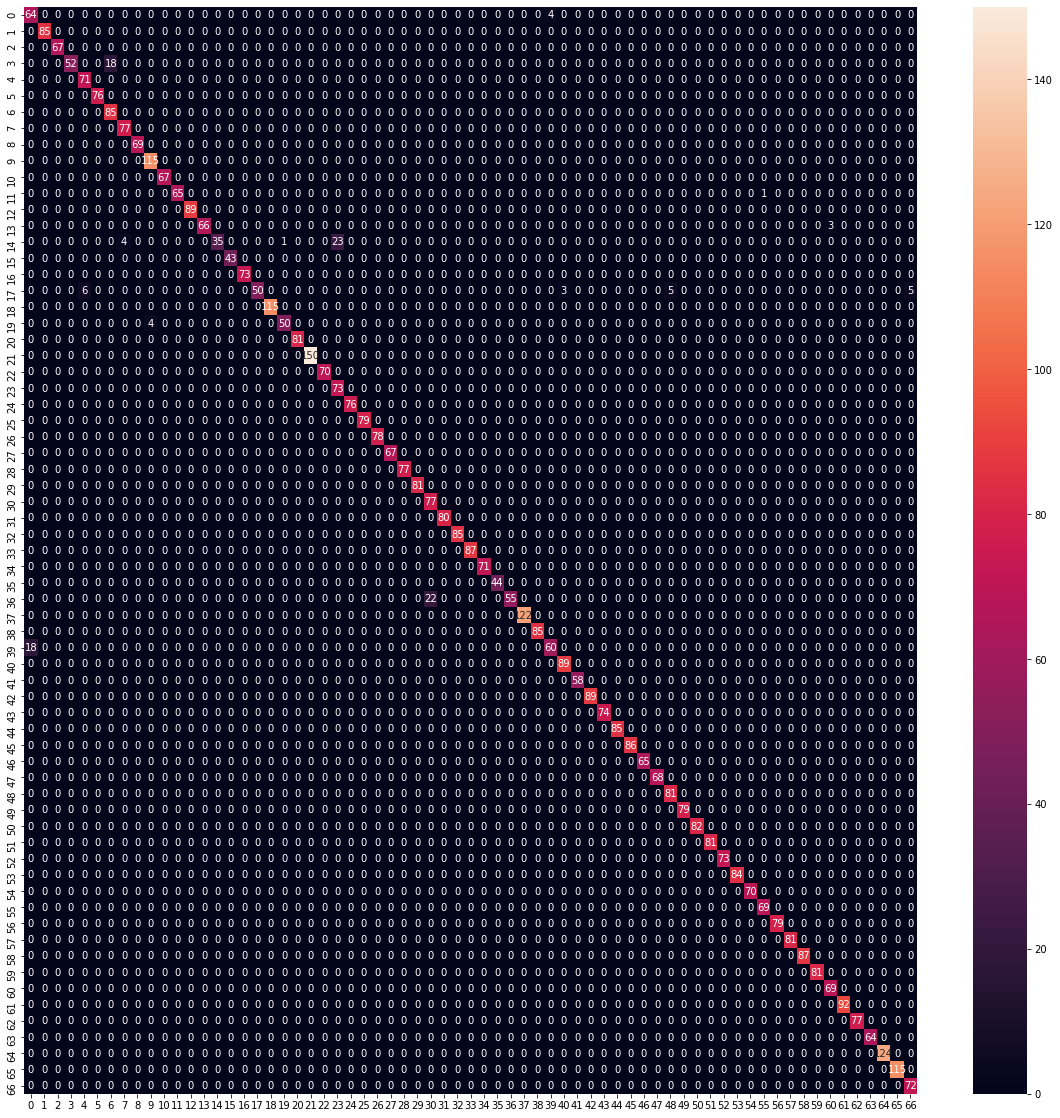

In [53]:
#confusion matrix
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
conf_mat=confusion_matrix(y_true,y_pred_classes)
f,ax=plt.subplots(figsize=(20, 20))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
plt.show()

In [54]:
# 모델3이 헷갈린 과일 종류
print("It's", fruit_names[30], "but model3 predict", fruit_names[36], "22")
print("It's", fruit_names[23], "but model3 predict", fruit_names[14], "23")

It's Lemon but model3 predict Maracuja 22
It's Guava but model3 predict Corn 23


## 8. Evaluation Metrix

In [41]:
y_test2 = np.argmax(y_test, axis = 1)
y_pred2 = np.argmax(y_pred, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        68
           1       1.00      1.00      1.00        85
           2       1.00      1.00      1.00        67
           3       1.00      0.74      0.85        70
           4       0.92      1.00      0.96        71
           5       1.00      1.00      1.00        76
           6       0.83      1.00      0.90        85
           7       0.95      1.00      0.97        77
           8       1.00      1.00      1.00        69
           9       0.97      1.00      0.98       115
          10       1.00      1.00      1.00        67
          11       1.00      0.98      0.99        66
          12       1.00      1.00      1.00        89
          13       1.00      0.96      0.98        69
          14       1.00      0.56      0.71        63
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        73
          17       1.00    